In [1]:
! pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
! pip3 install numpy --pre torch torchvision torchaudio --force-reinstall --index-url https://download.pytorch.org/whl/nightly/cu118

Looking in indexes: https://download.pytorch.org/whl/nightly/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.7/809.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

In [63]:
from transformers import pipeline
from PIL import Image

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load an image

Let's use the image that has been used for Llava demo

And ask the model to describe that image!

In [25]:
image_path = '/content/drive/MyDrive/NLP/img2text/sample1.jpg'
image = Image.open(image_path)

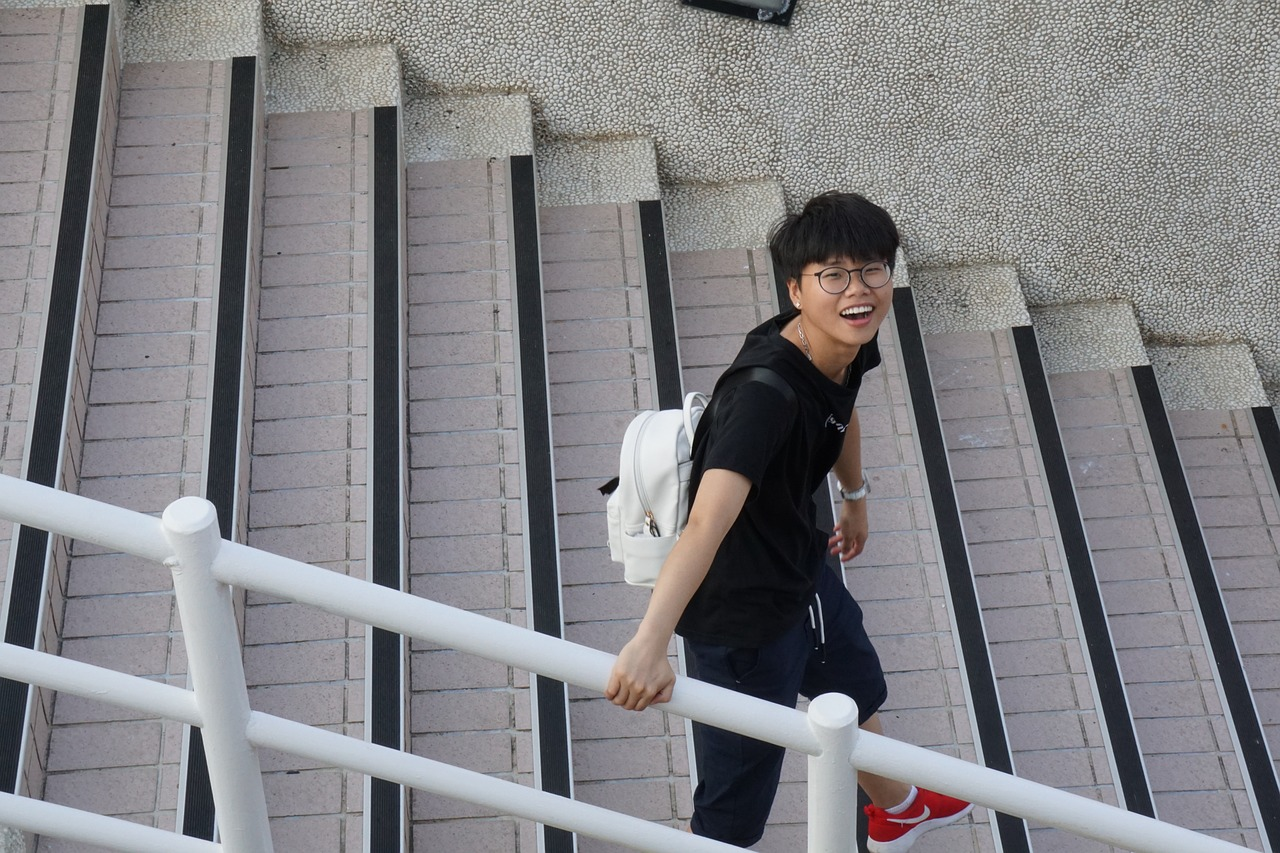

In [6]:
image

## Preparing the quantization config to load the model in 4bit precision

In order to load the model in 4-bit precision, we need to pass a `quantization_config` to our model. Let's do that in the cells below

In [7]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [8]:
print(torch.__version__)

2.2.0.dev20231211+cu118


## Load the model using `pipeline`

We will leverage the `image-to-text` pipeline from transformers !

In [9]:
from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

config.json:   0%|          | 0.00/922 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

It is important to prompt the model wth a specific format, which is:
```bash
USER: <image>\n<prompt>\nASSISTANT:
```

In [28]:
max_new_tokens = 200
prompt = "USER: <image>\nCan you describe about this picture?\nASSISTANT:"

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

In [29]:
outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
print(outputs[0]["generated_text"])

USER:  
Can you describe about this picture?
ASSISTANT: The image features a young man wearing glasses and a backpack, walking down a flight of stairs. He appears to be in a hurry, possibly rushing to catch a bus or reach his destination. The stairs are visible in the background, and the man is the main focus of the scene.


In [30]:
full_description=outputs[0]["generated_text"]

In [14]:
from pprint import pprint
assistant_description = full_description.split("?")[1].strip()
pprint(assistant_description)

('ASSISTANT: The image features a young man wearing glasses and a backpack, '
 'walking down a flight of stairs. The stairs are made of concrete, and the '
 'man appears to be in a hurry. The scene suggests that the man might be in a '
 'hurry to reach a specific destination, possibly a public transportation stop '
 'or a workplace. The presence of the backpack indicates that he might be '
 'carrying personal belongings or work-related items.')


('ASSISTANT: The image features a young man wearing glasses and a backpack, '
 'walking down a flight of stairs. The stairs are made of concrete, and the '
 'man appears to be in a hurry. The scene suggests that the man might be in a '
 'hurry to reach a specific destination, possibly a public transportation stop '
 'or a workplace. The presence of the backpack indicates that he might be '
 'carrying personal belongings or work-related items.')


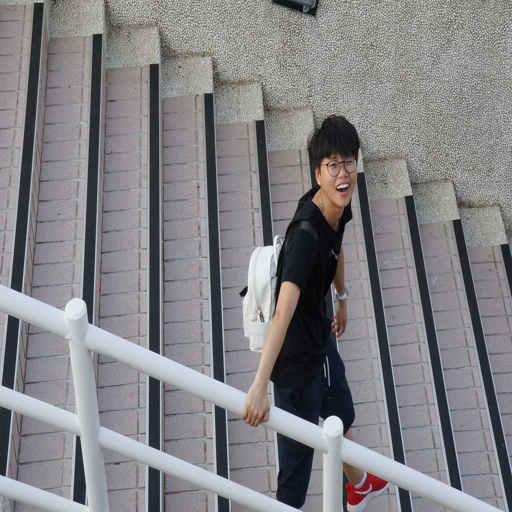

In [31]:
pprint(assistant_description)
image = image.resize((512,512))
image

In [54]:
# import requests
# # url = "https://media.istockphoto.com/id/1473467333/photo/cheerful-parents-assisting-son-in-flying-at-park.jpg?s=1024x1024&w=is&k=20&c=o5r2UWXdxr6IoBUlDAXd7F4_5nglPFdU7oSCiSGruyw="

# # image = Image.open(requests.get(url, stream=True).raw)
# im_path = "/content/drive/MyDrive/NLP/img2text/family.jpg"
# image = Image.open(image_path)
# image = image.resize((512,512))
# image

('ASSISTANT: The image features a family of three, consisting of a man, a '
 'woman, and a young boy, all posing together for a picture. The man and woman '
 'are standing close to each other, while the boy is positioned between them. '
 'They are all smiling, creating a warm and happy atmosphere.\n'
 '\n'
 'In the background, there are several birds flying, adding a sense of motion '
 'and life to the scene. The birds are scattered throughout the image, with '
 'some closer to the foreground and others further away.')


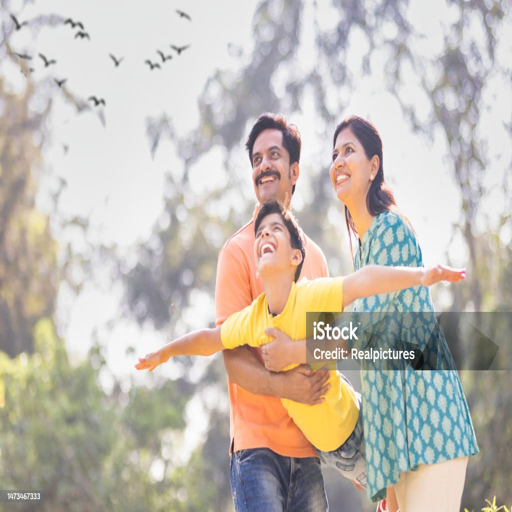

In [36]:
outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
result = outputs[0]["generated_text"]
full_description= result.split("?")[1].strip()
pprint(full_description)
image


In [ ]:
#----- CODE-------

In [62]:
from PIL import Image
import requests
# img = Image.open("/content/drive/MyDrive/NLP/img2text/sample1.jpg")
# url = "https://media.istockphoto.com/id/1473467333/photo/cheerful-parents-assisting-son-in-flying-at-park.jpg?s=1024x1024&w=is&k=20&c=o5r2UWXdxr6IoBUlDAXd7F4_5nglPFdU7oSCiSGruyw="
# image = Image.open(requests.get(url, stream=True).raw)
# image = image.resize((512,512))
# image

# import cv2
# image = cv2.imread('/content/drive/MyDrive/NLP/img2text/family.jpg')
# cv2.imshow("OpenCV Image",image)
# img

In [59]:
def im2txt(image_url):
  image = Image.open(requests.get(image_url, stream=True).raw)
  image = image.resize((512,512))
  outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
  result = outputs[0]["generated_text"]
  full_description= result.split("?")[1].strip()
  return image, full_description

In [60]:
url

'https://media.istockphoto.com/id/1473467333/photo/cheerful-parents-assisting-son-in-flying-at-park.jpg?s=1024x1024&w=is&k=20&c=o5r2UWXdxr6IoBUlDAXd7F4_5nglPFdU7oSCiSGruyw='

('ASSISTANT: The image features a man with a shaved head, wearing a black '
 'shirt and a brown watch. He is standing near a body of water, possibly a '
 'lake or a river, with a boat visible in the background. The man appears to '
 'be scratching his head, possibly indicating confusion or contemplation.\n'
 '\n'
 'There are several other people in the scene, some of them closer to the '
 'water, while others are further away. The presence of multiple people '
 'suggests that this location might be a popular spot for gatherings or '
 'outdoor activities.')


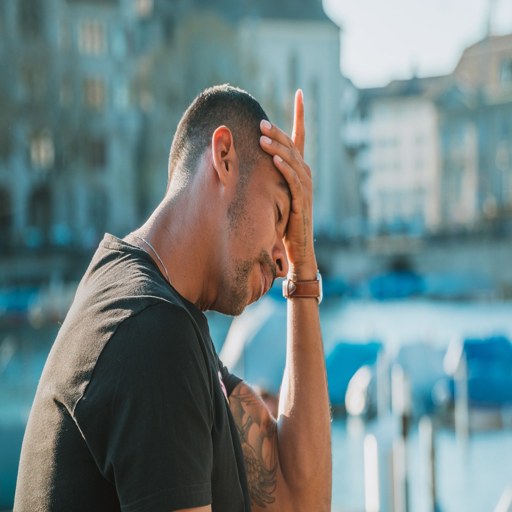

In [61]:
Image,caption = im2txt(image_url = "https://cdn.pixabay.com/photo/2020/04/07/04/17/desperate-5011953_1280.jpg")
pprint(caption)
Image